In [1]:
# Import necessary libraries

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import alpaca_trade_api as tradeapi
import pandas as pd

# Set defaults for plotting
from IPython import display
%matplotlib inline
plt.rcParams['font.size'] = 15
plt.rcParams['figure.figsize'] = (7, 5)
#plt.style.use('classic')  #'fivethirtyeight'  # 'ggplot'

In [2]:
# Constants required for access to alpaca API to pull stock data

key_dir = 'C:\\Users\\Dan\\Documents\\Python Scripts\\apiKeys\\'
apiKey = open(key_dir + 'alpaca_apiKey.txt', 'r').read()
secretKey = open(key_dir + 'alpaca_secretKey.txt', 'r').read()
endPoint = 'https://paper-api.alpaca.markets'  # Specify this for demo account

# Define the companies you want the data for
tickers = ['AAPL', 'MSFT']

# Define dates between which we extract the stock data
startDate = '2020-01-01'
endDate = '2020-05-28'

# Connect to the API and pull the data
api = tradeapi.REST(apiKey, secretKey, endPoint, api_version='v2')

In [3]:
# Define the dictionary that will hold all the data for all the companies
ohlcv = {}
for ticker in tickers:
    try:
        # Pull the stock details for that ticker
        ohlcv[ticker] = api.get_aggs(ticker, 1, 'day', startDate, endDate).df
        # Calculate their daily return
        ohlcv[ticker]['daily return'] = ohlcv[ticker]['close'].pct_change()
        print('Pulling ohlcv data for {:s}'.format(ticker))
    except:
        # If nothing is found, throw error and continue
        print('Error encountered pulling ohlcv data for {:s}'.format(ticker))

Pulling ohlcv data for AAPL
Pulling ohlcv data for MSFT


# Two transformations are required to perform the Gramian Angular Field transformation:

### 1) Min-Max scaling

In [4]:
# Define a copy of the data for quick test
timeSeries = ohlcv['AAPL']['close'].iloc[:50].copy()
data = timeSeries.to_numpy().reshape(len(timeSeries),1)

# Print some outputs
print('Original close price time series:')
print(data[:10])
print(' ')
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(data)
print('Min max scaled close price time series:')
print(scaler.transform(data[:10]))

# Transform the data you care about
scaledTimeSeries = scaler.transform(data)

Original close price time series:
[[300.58]
 [297.38]
 [299.78]
 [298.27]
 [303.15]
 [309.71]
 [310.37]
 [316.97]
 [312.69]
 [311.5 ]]
 
Min max scaled close price time series:
[[0.32777778]
 [0.2469697 ]
 [0.30757576]
 [0.26944444]
 [0.39267677]
 [0.55833333]
 [0.575     ]
 [0.74166667]
 [0.63358586]
 [0.60353535]]


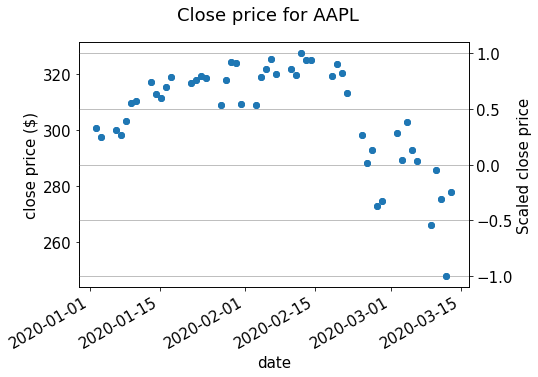

In [5]:
# Plot the close price and the standardised values

fig1, ax1 = plt.subplots()
ax1.plot_date(timeSeries.index, data)
plt.gcf().autofmt_xdate()
#ax1.xaxis.grid(False)  # Don't want the left axis to have grid lines too - looks messy
ax2 = ax1.twinx()
ax2.plot_date(timeSeries.index, scaler.transform(data))
ax2.yaxis.grid(True)

# Figure formatting
ax1.set_ylabel('close price ($)')
ax2.set_ylabel('Scaled close price')
ax1.set_xlabel('date')
plt.suptitle('Close price for ' + tickers[0])
plt.show()

### 2) Conversion to polar coordinates to encode magnitude and time

In [6]:
def convertToPolar(scaledTimeSeries):
    '''Input is a 1D numpy array of time series numbers (no index)'''
    N = len(scaledTimeSeries)

    phi = np.arccos(scaledTimeSeries)
    radius = np.arange(N)/N

    return phi, radius

In [7]:
# Call the above function to retrieve the transformed data
phi, rad = convertToPolar(scaledTimeSeries)

# Define the gram matrix as the (proxy for) inner products of the angles of the time series transformation
gram = np.vectorize(lambda x,y: np.cos(x + y))(*np.meshgrid(phi, phi, sparse=True))  # no rad?

In the polar plot below, the angle is proportional to time whilst the distance of the line from the origin (0) is proportional to the price

Note that in the anonymous vectorised function used when calculating gram, the radius is not comupted when calculating the proxy of the inner product. This is because we want to avoid biasing the results to the more recent observations as these would have the shortest norms. Therefore, only the angle should be used, hence the application of $\mathrm{cos}(x+y)$ to arguments of $\phi$ and $\phi$, not $r$.

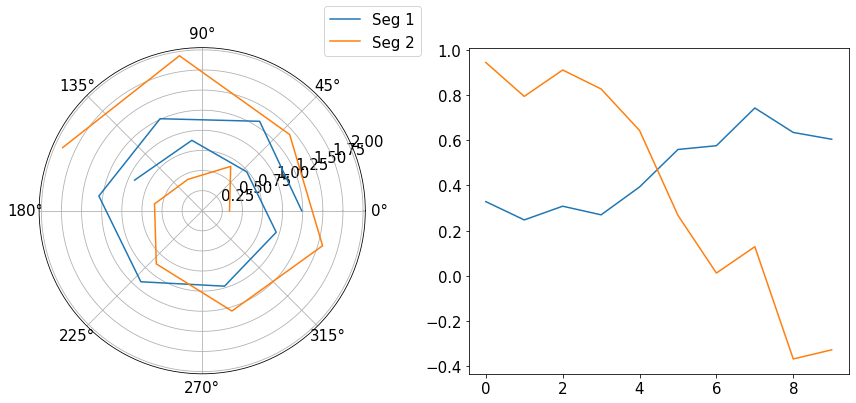

In [8]:
# Plot a few extracts of the data to see what's happening

fig = plt.figure(figsize=(15,6))
ax1 = plt.subplot(121, projection='polar')
ax2 = plt.subplot(122)
#ax1.plot(subset[:20,[1, 5]])
ax1.plot(phi[:10], label='Seg 1')
ax1.plot(phi[30:40], label='Seg 2')
fig.legend(loc='upper left', bbox_to_anchor=(0.85,1.15), bbox_transform=ax1.transAxes)
ax2.plot(scaledTimeSeries[:10], label='Segment 1')
ax2.plot(scaledTimeSeries[30:40], label='Segment 1')
plt.show()
# Not convinced the two lines here have much relation to eachother, but the general point is valid. Time series -> polar stuff

Now write a compact version of the above that does everything in one function

In [27]:
def gramianAngularField(timeSeries, sumOrDifference='sum'):
    ''' Inputs: 
            timeSeries is a possible pandas column representing the timeSeries you want to transform.
            
            sumOrDifference is a string denoting whether you want the gramian angular summation field or
            the gramian angular difference field
    '''
    N = len(timeSeries)
    
    # If timeSeries is numpy, just reshape, if it's other (pandas dataframe) recast as numpy before reshaping
    if type(timeSeries).__module__ == np.__name__:
        data = timeSeries.reshape(N, -1)
    else:
        data = timeSeries.to_numpy().reshape(N, -1)
        
    # Scale and transform to polar
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaler.fit(data)
    data_scaled = scaler.transform(data)
    phi = np.arccos(data_scaled)  # Remember we don't want to include the radius as this is a form of temporal bias
    
    # Calculate gram angular field in either summation or difference mode
    if sumOrDifference in ['sum', 'Sum', '+']:
        # 'Dot' product across all the transformed representations in this series
        gram = np.vectorize(lambda x,y: np.cos(x + y))(*np.meshgrid(phi, phi, sparse=True))
    else:
        gram = np.vectorize(lambda x,y: np.sin(x + y))(*np.meshgrid(phi, phi, sparse=True))
    # Note - plot the gram with plt.imshow(gram) to get it to look like it should
    
    return gram

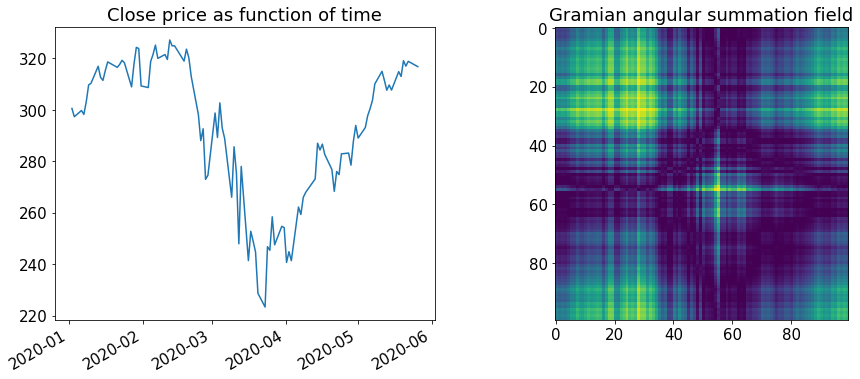

In [28]:
# Plot a few extracts of the data to see what's happening

T = len(ohlcv['AAPL']) - 1
for currentTime in range(1, T):
    # New data and define the host figure
    closeData = ohlcv['AAPL']['close'][:currentTime]
    plt.figure(figsize=(15,6), num=1)
    
    # Plot the time series
    plt.subplot(1, 2, 1)
    plt.plot(closeData)
    plt.gcf().autofmt_xdate()
    plt.title('Close price as function of time')
    
    # Plot the gramian angular summation field
    plt.subplot(1, 2, 2)
    plt.imshow(gramianAngularField(closeData, 'sum'))
    plt.title('Gramian angular summation field')
    
    # Update the plot(s)
    display.clear_output(wait=True)
    plt.pause(0.02)

So loosly speaking, it looks like that as time increases, the square gramian gains more rows and columns (time increases down the main diagonal), and the bright spots in the upper left / lower right correspond to the high points of the closing price.

The dark cross corresponds to the low point of the close price at the end of march 2020.

In [50]:
# x_test = np.linspace(0, 20*np.pi, 1000)
# plt.imshow(gramianAngularField(np.sin(x_test), 'sum'))
# plt.show()